In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

import nltk 
from nltk.stem import WordNetLemmatizer

import re
import codecs
import unidecode

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers

# Import data

In [2]:
train = pd.read_csv('sentiment_train.csv', names=['index','text','sentiment'], header=0)
train.drop('index', axis=1, inplace=True)
train

,text,sentiment
0,⚠️ #TLUpdates - Due to a safety inspection of ...,negative
1,@TLRailUK On the announcement we were told tha...,negative
2,1418 Thameslink train to Horsham: On time - pl...,neutral
3,This morning's Thameslink train is covered in ...,neutral
4,"@TLRailUK I think a bit before Mill Hill, but ...",negative
...,...,...
11373,@TLRailUK She was the ticket lady at Arlesey t...,positive
11374,@TLRailUK perhaps you could have your train dr...,negative
11375,1323 Great Northern train to Moorgate: Delayed...,neutral
11376,Now stuck at harpenden. Not meant to stop here...,negative


In [3]:
validation = pd.read_csv('sentiment_validation.csv', names=['index','text','sentiment'], header=0)
validation.drop('index', axis=1, inplace=True)
validation

,text,sentiment
0,What dirt does @GatwickExpress have on @TLRail...,negative
1,@EmilyTrenouth @TLRailUK Can’t see a carriage ...,neutral
2,@TLRailUK The 18:57 Cambridge to KingsX was de...,negative
3,@SouthernRailUK @TLRailUK @GatwickExpress @MET...,neutral
4,@TLRailUK Thank you for coming back to me. It'...,negative
...,...,...
2003,@TLRailUK Thanks.......It said it arrived ? Ca...,negative
2004,@TLRailUK Can anyone there explain to me why I...,neutral
2005,2005 Thameslink train to Gatwick Airport: Dela...,neutral
2006,.@networkrail @TLRailUK which person designed ...,negative


In [4]:
test = pd.read_csv('sentiment_test.csv', names=['index','text','sentiment'], header=0)
test.drop('index', axis=1, inplace=True)
test

,text,sentiment
0,#TLUpdates - We have been advised by our colle...,neutral
1,@TLRailUK Aiming ... like chucking a hot dog u...,negative
2,Long time since I’ve had to get a @TLRailUK tr...,negative
3,@thomasbrake @TLRailUK Can I ask for your view...,neutral
4,@TLRailUK how is it even possible for you to c...,negative
...,...,...
2358,⚠️ #TLUpdates - Services are beginning to retu...,negative
2359,⚠️#TLUpdates - Train services running through ...,neutral
2360,@LiveCommute @tlupdates @WorkerRailway @SaaSyS...,negative
2361,"@TLRailUK Hey, how do I do the ‘return unused ...",neutral


# CLEANING TWEET CONTENT

In [5]:
# load spacy English language model trained based on web and social media texts
# add more stop words to the list of stop words list in spacy

nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {'thameslink','tlupdates','gtrailuk','tlrailuk','govia', 'gtr'}
nlp.Defaults.stop_words.remove('not')

C:\Users\public\anaconda3\lib\site-packages\spacy\util.py:885: UserWarning: [W094] Model 'en_core_web_sm' (2.2.0) specifies an under-constrained spaCy version requirement: >=2.2.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.4.2,<3.5.0
  warnings.warn(warn_msg)


OSError: [E053] Could not read config file from C:\Users\public\anaconda3\lib\site-packages\en_core_web_sm\en_core_web_sm-2.2.0\config.cfg

In [ ]:
STOP_WORDS

print(len(STOP_WORDS))
print(STOP_WORDS)

In [ ]:
# Create a function to clean tweet content
# Tweet will be cleaned by the following steps:
# 1. Remove emoji
# 2. Remove #thameslink, #TLUpdates, @gtrailuk, @TLRailUK
# 3. Turn word to lowercase
# 4. Remove Twitter @usernames
# 5. Remove hyperlink
# 6. Remove punctuations
# return clean text

def cleanText(text):
    #create a list of emojis pattern
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   "]+", flags = re.UNICODE)
    text = re.sub(emoji_pattern,'', text) #remove emoji    
    text = re.sub(r'#thameslink','',text) #remove #thameslink
    text = re.sub(r'#TLUpdates','',text) #remove #TLUpdates
    text = re.sub(r'@gtrailuk','',text) #remove @gtrailuk
    text = re.sub(r'@TLRailUK','',text) #remove @TLRailUK
    
    text = text.lower() #turn every capitalization to lowercase    
    text = re.sub(r'@[A-Za-z0-9\_]+','',text) #remove @usernames, format of a username: alphanumeric characters (letters A-Z, numbers 0-9) with the exception of underscores
    text = re.sub(r'https?:\/\/\S+','',text) #remove hyperlink
    text = re.sub(r'\b\d+\b','',text) #remove numbers
    text = re.sub(r'[^\w\s]','',text) #remove punctuations
    return text

In [ ]:
# Clean the tweet content
# Use for loop to run through every tweets in the clean dataset
# Cleaning steps include:
# 1. Basic clean (i.e. remove unnecessary emojis, patterns, punctuation...) using the cleanText function above
# 2. Tokenization: break sentence into words
# 3. Remove stop words
# 4. Lemmatization: strip words down to its root/stem
# return a DataFrame with clean words

def cleanSentence(main_df):
    df = main_df.copy()
    lemmatizer = WordNetLemmatizer()

    for index, row in df.iterrows():
        filter_sentence = []
        sentence = cleanText(row['text']) # call our function above to clean user text
        words = nltk.word_tokenize(sentence) # tokenization
        words = [w for w in words if not w in STOP_WORDS] # stopwords removal
        for word in words:
            filter_sentence.append(lemmatizer.lemmatize(word)) # lemmatization
        clean_sentence = ' '.join(str(x) for x in filter_sentence if not len(x) == 1)
        df.at[index,'text'] = clean_sentence  
    return df

# SENTIMENT ANALYSIS WITH NEURAL NETWORK

# Create dataset for Neural Network

In [6]:
# right now, the model perform much better on unclean text. Clean text can always been done by uncheck the hastags below

train_nn = train.copy()
#train_nn = cleanSentence(train_nn)
train_nn

,text,sentiment
0,⚠️ #TLUpdates - Due to a safety inspection of ...,negative
1,@TLRailUK On the announcement we were told tha...,negative
2,1418 Thameslink train to Horsham: On time - pl...,neutral
3,This morning's Thameslink train is covered in ...,neutral
4,"@TLRailUK I think a bit before Mill Hill, but ...",negative
...,...,...
11373,@TLRailUK She was the ticket lady at Arlesey t...,positive
11374,@TLRailUK perhaps you could have your train dr...,negative
11375,1323 Great Northern train to Moorgate: Delayed...,neutral
11376,Now stuck at harpenden. Not meant to stop here...,negative


In [7]:
test_nn = test.copy()
#test_nn = cleanSentence(test_nn)
test_nn

,text,sentiment
0,#TLUpdates - We have been advised by our colle...,neutral
1,@TLRailUK Aiming ... like chucking a hot dog u...,negative
2,Long time since I’ve had to get a @TLRailUK tr...,negative
3,@thomasbrake @TLRailUK Can I ask for your view...,neutral
4,@TLRailUK how is it even possible for you to c...,negative
...,...,...
2358,⚠️ #TLUpdates - Services are beginning to retu...,negative
2359,⚠️#TLUpdates - Train services running through ...,neutral
2360,@LiveCommute @tlupdates @WorkerRailway @SaaSyS...,negative
2361,"@TLRailUK Hey, how do I do the ‘return unused ...",neutral


In [8]:
validation_nn = validation.copy()
#validation_nn = cleanSentence(validation_nn)
validation_nn

,text,sentiment
0,What dirt does @GatwickExpress have on @TLRail...,negative
1,@EmilyTrenouth @TLRailUK Can’t see a carriage ...,neutral
2,@TLRailUK The 18:57 Cambridge to KingsX was de...,negative
3,@SouthernRailUK @TLRailUK @GatwickExpress @MET...,neutral
4,@TLRailUK Thank you for coming back to me. It'...,negative
...,...,...
2003,@TLRailUK Thanks.......It said it arrived ? Ca...,negative
2004,@TLRailUK Can anyone there explain to me why I...,neutral
2005,2005 Thameslink train to Gatwick Airport: Dela...,neutral
2006,.@networkrail @TLRailUK which person designed ...,negative


In [9]:
X_train_nn = train_nn['text']
y_train_nn = train_nn['sentiment']

X_test_nn = test_nn['text']
y_test_nn = test_nn['sentiment'] 

X_val_nn = validation_nn['text']
y_val_nn = validation_nn['sentiment'] 

## Tokenization

In [10]:
#build the dictionary

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_nn) #run through every tweet in training set to get the words in each tweet to build the dictionary later on

x_train = tokenizer.texts_to_sequences(X_train_nn) #transform words into numbers 
x_test = tokenizer.texts_to_sequences(X_test_nn) #transform words into numbers 

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [11]:
print(X_train_nn[0])
print(x_train[0])

⚠️ #TLUpdates - Due to a safety inspection of the track being undertaken by Network Rail at Norwood Junction, services are subject to delay or cancellation. ℹ️ More details to follow once we have it.
[148, 53, 26, 1, 7, 764, 1378, 11, 2, 347, 67, 5867, 58, 266, 161, 10, 616, 466, 44, 16, 233, 1, 45, 46, 355, 240, 81, 390, 1, 421, 439, 50, 27, 18]


## Padding

In [12]:
lens_train = [len(i) for i in x_train]
lens_test = [len(i) for i in x_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 91


In [13]:
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

## Label Encoding

In [14]:
encoder = LabelEncoder()
encoder.fit(y_train_nn)

encoded_Y_train = encoder.transform(y_train_nn)
encoded_Y_test = encoder.transform(y_test_nn)


# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

## Modelling

In [17]:
embedding_dim = 1000  # vector representation of words/neuron amount after the input https://datascience.stackexchange.com/questions/53995/what-does-embedding-mean-in-machine-learning#:~:text=In%20the%20context%20of%20machine,with%20other%20models%20as%20well.

model = Sequential()  # initiates the model
model.add(layers.Embedding(input_dim=vocab_size,  # adds the first [input] layer which will be our tokenized tweets
                          output_dim=embedding_dim,  # the embedding of that tweet, essentially inputs output
                          input_length=maxlen))  # size of the input layer determined by maxlen calculated before
model.add(layers.Dropout(0.3))  # dorpouts are added to help with overtraining, essentially "turns off" said amount of neurons before giving information to the next layer
model.add(layers.GlobalMaxPool1D())  # https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))  # additional hidden layer
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))  # prediction layer, 2 is the number of classes we have
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 1000)          18439000  
                                                                 
 dropout_4 (Dropout)         (None, 91, 1000)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 1000)             0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 50)                50050     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                      

In [19]:
history = model.fit(x_train, dummy_y_train,
                    epochs=10,  # times model will run through the data
                    verbose=True,
                    validation_data=(x_test, dummy_y_test),
                    batch_size=160)  # data is set to batches we are sent to the model to predict, imagine each batc as a step in which model tries to predict the class and then checks the right answer and corrects it's weights with backpropogation
loss, accuracy = model.evaluate(x_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(x_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))




Epoch 1/10
72/72 [==============================] - 18s 252ms/step - loss: 0.4000 - accuracy: 0.8346 - val_loss: 0.5985 - val_accuracy: 0.7101
Epoch 2/10
72/72 [==============================] - 18s 252ms/step - loss: 0.3288 - accuracy: 0.8721 - val_loss: 0.6185 - val_accuracy: 0.7169
Epoch 3/10
72/72 [==============================] - 18s 250ms/step - loss: 0.2844 - accuracy: 0.8877 - val_loss: 0.6682 - val_accuracy: 0.7110
Epoch 4/10
72/72 [==============================] - 19s 258ms/step - loss: 0.2416 - accuracy: 0.9021 - val_loss: 0.6917 - val_accuracy: 0.7088
Epoch 5/10
72/72 [==============================] - 18s 248ms/step - loss: 0.2085 - accuracy: 0.9153 - val_loss: 0.7211 - val_accuracy: 0.7025
Epoch 6/10
13/72 [====>.........................] - ETA: 14s - loss: 0.1596 - accuracy: 0.9380

KeyboardInterrupt: 

## Evaluating Results

In [23]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

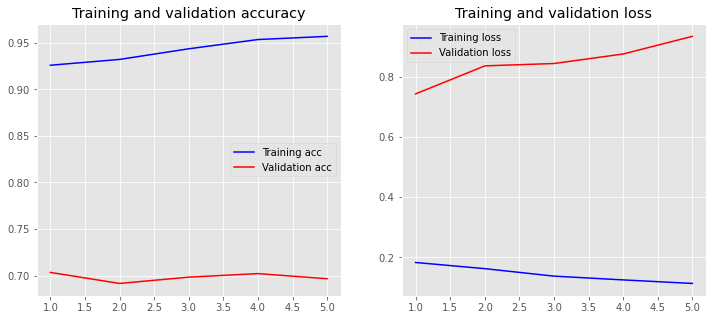

In [24]:
plot_history(history)

## Confusion matrix

In [25]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [26]:
y_pred = model.predict(x_test)
y_pred

74/74 [==============================] - 0s 4ms/step


array([[2.7193525e-01, 7.2385442e-01, 4.2102914e-03],
       [4.6570313e-01, 5.0187957e-01, 3.2417338e-02],
       [9.9989772e-01, 1.0042717e-04, 1.7953652e-06],
       ...,
       [1.0623447e-01, 8.8370734e-01, 1.0058164e-02],
       [9.7244376e-01, 2.7189918e-02, 3.6636536e-04],
       [9.9727768e-01, 2.6707081e-03, 5.1551608e-05]], dtype=float32)

In [31]:
y_predDecoded = [encoder.classes_[np.argmax(i)] for i in y_pred]  # here we get the max probability from those arrays and then based on that select which class is it.
cm = confusion_matrix(y_test_nn, y_predDecoded, labels=test.sentiment.unique())  # same confusion matrix code as in Logistic Regression
df_cm = pd.DataFrame(cm, index=test.sentiment.unique(), columns=test.sentiment.unique())
df_cm


,neutral,negative,positive
neutral,516,347,2
negative,339,1120,5
positive,12,12,10


In [32]:
print('Precision: %.3f' % precision_score(y_test_nn, y_predDecoded, average='weighted'))
print('Recall: %.3f' % recall_score(y_test_nn, y_predDecoded, average='weighted'))

Precision: 0.695
Recall: 0.697


In [33]:
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
    df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,neutral,negative,positive
neutral,0.595156,0.234618,0.117647
negative,0.391003,0.757268,0.294118
positive,0.013841,0.008114,0.588235
